In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt
import os


filePath = 'bikes.csv'
bikesData = pd.read_csv(filePath)
columnsToDrop = ['instant','atemp','casual','registered']
bikesData = bikesData.drop(columnsToDrop, axis = 1) 
columnsToScale = ['temp', 'hum', 'windspeed']
scaler = StandardScaler()
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,dayCount
0,2011-01-01,1,0,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,16,0.000000
1,2011-01-01,1,0,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,40,0.041667
2,2011-01-01,1,0,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,32,0.083333
3,2011-01-01,1,0,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,13,0.125000
4,2011-01-01,1,0,1,4,0,6,0,1,-1.334648,0.636370,-1.553889,1,0.166667


In [2]:
def display_scores(model,scores):
    #print(model,"Scores:", scores)
    print(model,"Mean:", scores.mean())
    print(model,"Standard deviation:", scores.std(),"\n")

In [3]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(bikesData, test_size=0.3)

train_set.sort_values(by=['dayCount'], axis= 0, inplace=True) 
test_set.sort_values(by=['dayCount'], axis= 0, inplace=True) 

print('train_set' , len(train_set))
print('test_set' , len(test_set))

trainingCols = train_set.drop(['cnt','dteday'], axis = 1) 
trainingLabels = train_set['cnt']


trainingCols.head()


train_set 12165
test_set 5214


/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,dayCount
0,1,0,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,0.000000
1,1,0,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,0.041667
2,1,0,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,0.083333
3,1,0,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,0.125000
5,1,0,1,5,0,6,0,2,-1.334648,0.636370,-0.821484,0.208333


In [4]:
# Train a Decision Tree Regressor
dec_reg = DecisionTreeRegressor(random_state = 42)
dt_mae_scores = -cross_val_score(dec_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error")
display_scores("Decision Tree Regressor ",dt_mae_scores)
dt_mse_scores = np.sqrt(-cross_val_score(dec_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error"))
display_scores("Decision Tree Regressor ",dt_mse_scores)

# Train a Linear Regressor
lin_reg = LinearRegression()
lr_mae_scores = -cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error")
display_scores("Linear Regressor ",lr_mae_scores)
lr_mse_scores = np.sqrt(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error"))
display_scores("Linear Regressor ",lr_mse_scores)

# Train a Random Forest Regressor
forest_reg = RandomForestRegressor(random_state=42,n_estimators=150 )
rf_mae_scores = -cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error")
display_scores("Random Forest Regressor ",rf_mae_scores)
rf_mse_scores = np.sqrt(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error"))
display_scores("Random Forest Regressor ",rf_mse_scores)


Decision Tree Regressor  Mean: 52.49987242139861
Decision Tree Regressor  Standard deviation: 18.006002858322887 

Decision Tree Regressor  Mean: 83.68738558373903
Decision Tree Regressor  Standard deviation: 27.689756691018427 

Linear Regressor  Mean: 109.0552193411634
Linear Regressor  Standard deviation: 30.93666492286685 

Linear Regressor  Mean: 139.66161394068055
Linear Regressor  Standard deviation: 37.27834535233187 

Random Forest Regressor  Mean: 41.78762245969021
Random Forest Regressor  Standard deviation: 16.702458848381013 

Random Forest Regressor  Mean: 65.15089818087799
Random Forest Regressor  Standard deviation: 25.654270667638432 



In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [120, 150], 
     'max_features': [10,12],
    'max_depth': [15, 28]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(trainingCols, trainingLabels)
print(grid_search.best_estimator_)
print(grid_search.best_params_)


feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)


final_model = grid_search.best_estimator_
print(type(final_model))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=28, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
{'max_depth': 28, 'max_features': 10, 'n_estimators': 120}
[0.00487474 0.00326146 0.00548449 0.58548923 0.00223115 0.01769563
 0.06787128 0.01755731 0.09855662 0.03029814 0.00959361 0.15708634]
<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [7]:
test_set.sort_values('dayCount', axis= 0, inplace=True)
test_x_cols = (test_set.drop(['cnt','dteday'], axis=1)).columns.values
test_y_cols = 'cnt'
X_test = test_set.loc[:,test_x_cols]
y_test = test_set.loc[:,test_y_cols]

test_set.loc[:,'predictedCounts_test'] = final_model.predict(X_test)
mse = mean_squared_error(y_test, test_set.loc[:,'predictedCounts_test'])
final_mse=np.sqrt(mse)
print(final_mse)

40.22797093934942


/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

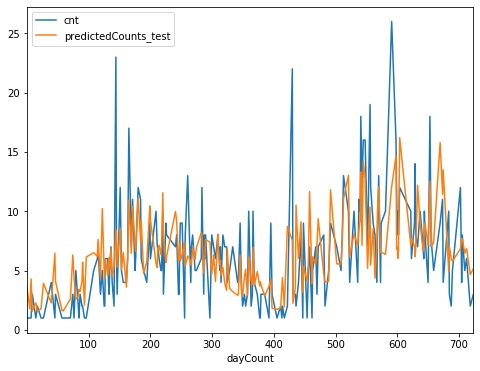

In [10]:
times = [4]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    test_set_freg_time = test_set[test_set.hr == time]
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts_test', ax =ax)
    plt.show()